# **Model robustness**

This script implements a **robustness test for qutrit-based quantum encoding and variational circuits** using both mathematical derivations and Pennylane simulations. It begins by defining the transverse and longitudinal impact parameters ($d_0$ and $z_0$) and then encodes a qutrit state on the Majorana sphere using specific angles. The Gram–Schmidt process is applied to construct a unitary matrix with the initial encoded state, and the correctness of the encoding is verified both mathematically and with Pennylane. 

The script then performs a **reverse process** based on Majorana polynomial roots to retrieve the original state and tests various rotations of the qutrits using defined rotation matrices. A variational layer is implemented with the **TAdd gate**, controlling two qutrits, followed by additional rotations. Throughout, the script compares the **mathematical predictions** with **Pennylane simulations**, confirming the consistency of state evolution, post-encoding states, and the final variational states. This demonstrates the validity and robustness of the quantum encoding and manipulation for qutrit-based systems.


In [24]:
import ijson
import numpy as np
import json
from decimal import Decimal
import json
import time
import torch
import warnings
import numpy as np
from IPython.display import clear_output
import pennylane as qml
from sklearn.model_selection import train_test_split
import pennylane as qml
import numpy as np
import torch
from scipy.linalg import expm
import numpy as np
from scipy.linalg import qr

import array_to_latex

The transverse and longitudinal impact parameters (IP), d0 and z0, are defined as the point
to the closest approach of the trajectory of a track to the primary vertex in the transverse
plane and z-direction, respectively

## Robustness test (Basic case)

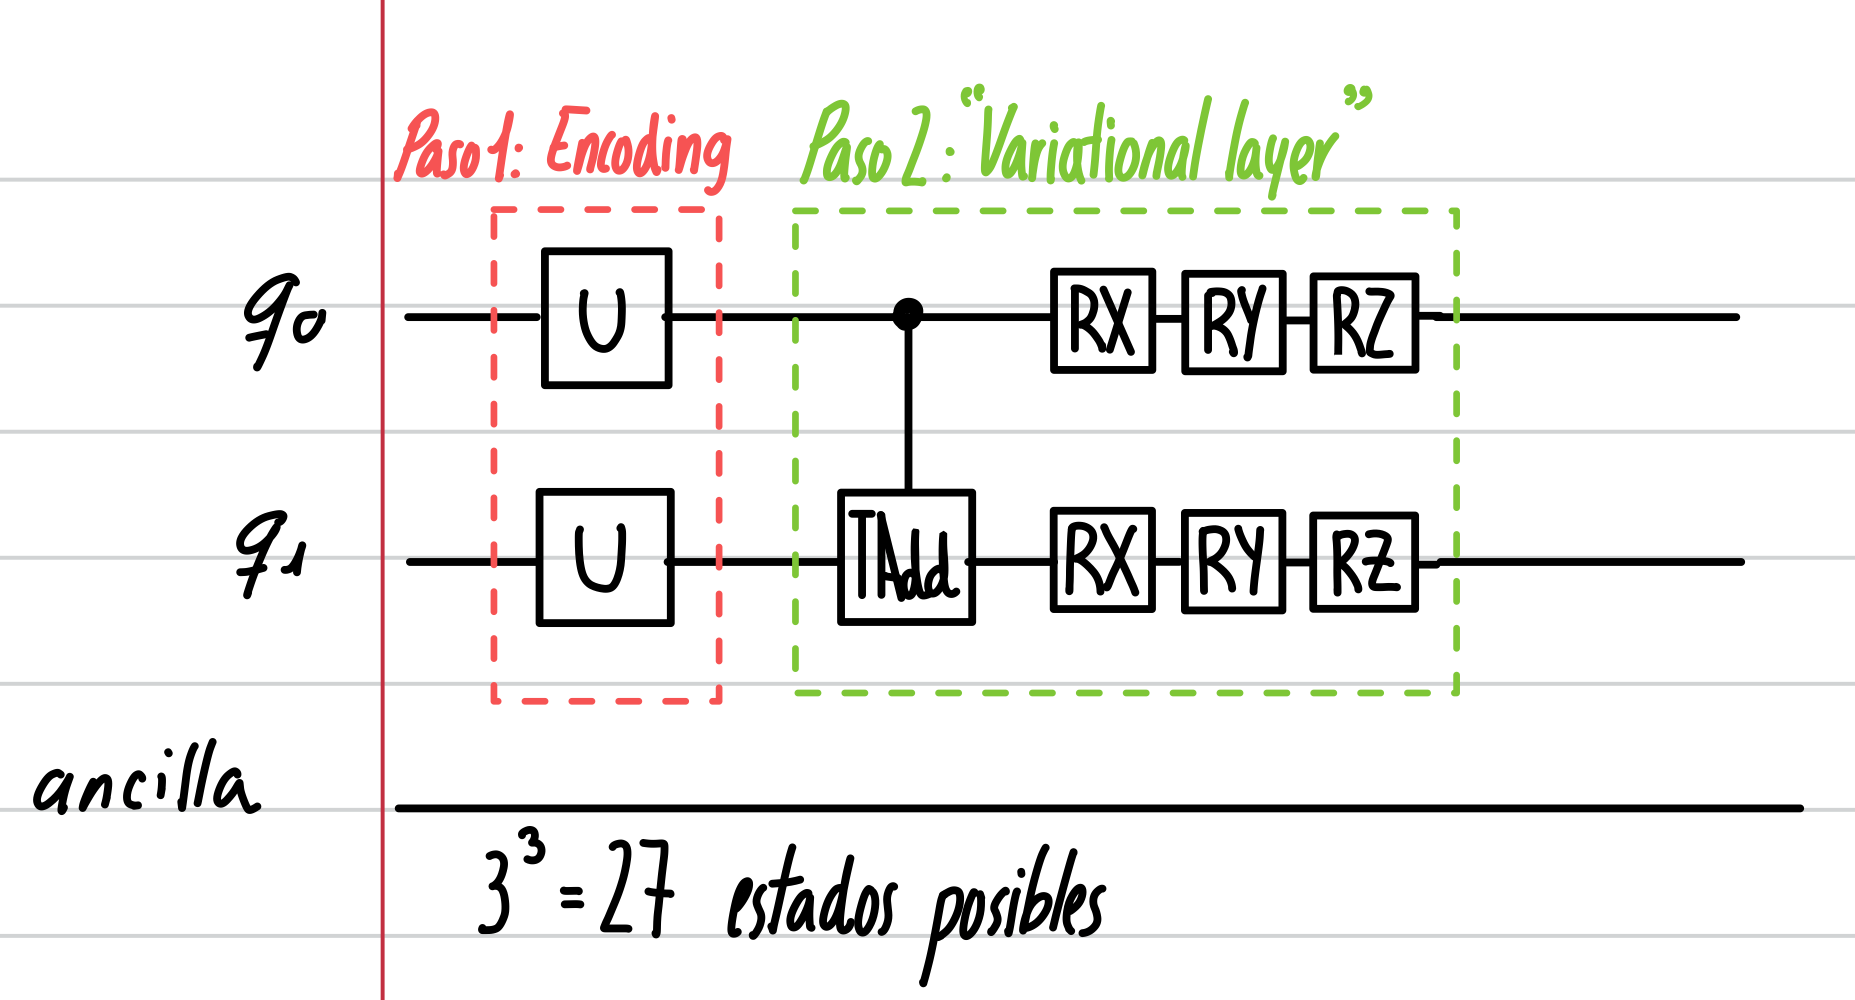

### **Step 1: Encoding**

We are going to validate the robustness of the model by replicating the results mathematically and graphically, checking later the similarity between results.

$\theta_1$ = $\frac{\pi}{2}$, $\theta_2$ = $\frac{\pi}{4}$, $\phi_1$ = $\frac{2\pi}{3}$ and $\phi_2$ = $\frac{3\pi}{4}$

Given these four angles, we can obtain a state of Majora such that:
$$

\ket{\psi_g} = \Gamma 
\begin{pmatrix}
e^{i \phi_1} \sin \frac{\theta_1}{2} \cos \frac{\theta_2}{2} 
+ e^{i \phi_2} \cos \frac{\theta_1}{2} \sin \frac{\theta_2}{2} \\[6pt]
\sqrt{2}\, e^{i(\phi_1+\phi_2)} \sin \frac{\theta_1}{2} \sin \frac{\theta_2}{2}
\end{pmatrix}
$$

$$
\Gamma = \sqrt{2}\,\Big[ 3 + \cos\theta_1 \cos\theta_2 
+ \sin\theta_1 \sin\theta_2 \cos(\phi_1 - \phi_2) \Big]^{-\tfrac{1}{2}}
$$

$$
\theta_i \in [0,\pi], 
\quad \phi_i \in [0,2\pi], 
\quad i = 1,2.
$$

$$
\Gamma : (0.7441)
$$

$$
\text{State: } 
\begin{bmatrix}
 0.6874 + 0.0j \\
-0.1007 - 0.3757j \\
-0.2466 + 0.1424j
\end{bmatrix}
$$

$$
\text{Norma: } 0.8396
$$

$$
\text{normalized state: }
\begin{bmatrix}
 0.8188 + 0.0j \\
-0.1199 - 0.4475j \\
-0.2937 + 0.1696j
\end{bmatrix}
$$

In [112]:
theta1 = torch.tensor(torch.pi) / torch.tensor(2)
theta2 = torch.tensor(torch.pi) / torch.tensor(4)
phi1 = torch.tensor(3) * torch.tensor(torch.pi) / torch.tensor(2)
phi2 = torch.tensor(4) * torch.tensor(torch.pi) / torch.tensor(3)

def inicializing_qutrit_state(theta1, theta2, phi1, phi2):
    Gamma= 0
    a0 = 0
    a1 = 0
    a2 = 0

    Gamma = torch.sqrt(torch.tensor(2.0)) * (torch.tensor(3.0) + torch.cos(theta1)*torch.cos(theta2) + torch.sin(theta1)*torch.sin(theta2)*torch.cos(phi1 - phi2))**(torch.tensor(-0.5))

    # Calcular las amplitudes
    a0 = (torch.sqrt(torch.tensor(2.0)) * torch.cos(theta1/2) * torch.cos(theta2/2)).item()
    a1 = (torch.exp(1j * phi1) * torch.sin(theta1/2) * torch.cos(theta2/2) + torch.cos(theta1/2) * torch.sin(theta2/2) * torch.exp(1j * phi2)).item()
    a2 = (torch.sqrt(torch.tensor(2.0)) * torch.exp(1j * (phi1 + phi2)) * torch.sin(theta1/2) * torch.sin(theta2/2)).item()


    # vecctor de estado
    state = Gamma * torch.tensor([a0, a1, a2], dtype=torch.cdouble)
    print('Gamma:', Gamma)
    print('State:', state)


    print('Norma: ',torch.linalg.norm(state))
    # NoOrmalizar 
    state = state / torch.linalg.norm(state)
    print('Estado normalizado:', state)
    

    return state.detach().clone().numpy()

A = inicializing_qutrit_state(theta1, theta2, phi1, phi2)
np.round(A, 2)

Gamma: tensor(0.7441)
State: tensor([ 0.6874+0.0000j, -0.1007-0.6605j, -0.2466+0.1424j],
       dtype=torch.complex128)
Norma:  tensor(1.0000, dtype=torch.float64)
Estado normalizado: tensor([ 0.6874+0.0000j, -0.1007-0.6605j, -0.2466+0.1424j],
       dtype=torch.complex128)


array([ 0.69+0.j  , -0.1 -0.66j, -0.25+0.14j])

In [111]:
def unitary_from_state(psi):

    psi = psi / np.linalg.norm(psi)  # por seguridad
    
    a1 = torch.tensor([0.555,0, 0.555], dtype=torch.cdouble)
    a2 = torch.tensor([0.555,0.555, 0], dtype=torch.cdouble)
    mat = np.column_stack([psi, a1 , a2])
    #print(mat)

    
    # QR para ortonormalizar columnas
    Q, R = qr(mat)
    print(np.round(Q, 2))
    # Ajustamos fase de la primera columna para que coincida exactamente con psi
    phase = np.vdot(psi, Q[:,0])
    Q[:,0] = Q[:,0] * (phase/abs(phase)).conj()
    
    return Q

Q = unitary_from_state(A)



[[-0.69+0.j   -0.52-0.07j  0.29-0.41j]
 [ 0.1 +0.66j -0.1 -0.21j  0.58+0.41j]
 [ 0.25-0.14j -0.81+0.07j -0.29+0.41j]]


### Using the Gram–Schmidt process, we can create our unitary matrix where the state resulting from the initial encoding is found in column 1. 

Let us consider the **Gram–Schmidt process** applied to the columns of the full-rank matrix.
$$
A = \begin{bmatrix} \mathbf{a}_1 & \cdots & \mathbf{a}_n \end{bmatrix},
$$
with intern product
$$
\langle \mathbf{v}, \mathbf{w} \rangle = \mathbf{v}^\top \mathbf{w} 
\quad (\text{o } \langle \mathbf{v}, \mathbf{w} \rangle = \mathbf{v}^\dagger \mathbf{w} \text{ in the complex case}).
$$

We define the projection:
$$
\operatorname{proj}_{\mathbf{u}} \mathbf{a} = \frac{\langle \mathbf{u}, \mathbf{a} \rangle}{\langle \mathbf{u}, \mathbf{u} \rangle}\,\mathbf{u}.
$$

Then:
$$
\mathbf{u}_1 = \mathbf{a}_1,
$$
$$
\mathbf{u}_2 = \mathbf{a}_2 - \operatorname{proj}_{\mathbf{u}_1} \mathbf{a}_2,
$$
$$
\mathbf{u}_3 = \mathbf{a}_3 - \operatorname{proj}_{\mathbf{u}_1} \mathbf{a}_3 - \operatorname{proj}_{\mathbf{u}_2} \mathbf{a}_3,
$$
$$
\vdots
$$
$$
\mathbf{u}_k = \mathbf{a}_k - \sum_{j=1}^{k-1} \operatorname{proj}_{\mathbf{u}_j} \mathbf{a}_k.
$$

Finally, the orthonormal vectors are obtained as:
$$
\mathbf{e}_1 = \frac{\mathbf{u}_1}{\|\mathbf{u}_1\|}, \quad
\mathbf{e}_2 = \frac{\mathbf{u}_2}{\|\mathbf{u}_2\|}, \quad
\mathbf{e}_3 = \frac{\mathbf{u}_3}{\|\mathbf{u}_3\|}, \quad
\ldots \quad
\mathbf{e}_k = \frac{\mathbf{u}_k}{\|\mathbf{u}_k\|}.
$$

Therefore, our unit vector with the initial state we want to encode in the first column would be as follows:
$$
U = Q = [ e_1, e_2, e_3]
$$



In [110]:
e1 = 0
e2 = 0
e3 = 0
u2 = 0
u3 = 0


print('Matriz Q:')
print(np.round(Q,4))
print('-----------------------------------------------------')
e1 = np.array([0.8187, -0.1199-0.4474j, -0.2937+0.1696j])
a2 = np.array([0.555,0,0.555])
a3 = np.array([0.555,0.555,0])

print('e1: ',np.round(e1,4))
print('-----------------------------------------------------')

proj = (np.vdot(e1, a2)/np.vdot(e1, e1)) * e1
u2 = a2 - proj
e2 = u2/np.linalg.norm(u2)

print('e2: ',np.round(e2,4))

print('-----------------------------------------------------')
e3 = 0
u3 = a3 - ((np.vdot(e1, a3)/np.vdot(e1, e1)) * e1) - ((np.vdot(u2, a3)/np.vdot(u2, u2)) * u2)
e3 = u3/np.linalg.norm(u3)
print('e3: ',np.round(e3,4))


Matriz Q:
[[ 0.6874+0.j     -0.5216-0.0732j  0.2887-0.4082j]
 [-0.1007-0.6605j -0.1036-0.2072j  0.5774+0.4082j]
 [-0.2466+0.1424j -0.8146+0.0732j -0.2887+0.4082j]]
-----------------------------------------------------
e1:  [ 0.8187+0.j     -0.1199-0.4474j -0.2937+0.1696j]
-----------------------------------------------------
e2:  [0.4378+0.1067j 0.1066+0.1648j 0.8643-0.1067j]
-----------------------------------------------------
e3:  [ 0.1654-0.315j  0.8048+0.315j -0.1654+0.315j]


Verified that the creation of the unitary works:

$$
\ket{\psi} = U\ket{0} = \begin{bmatrix}
0.8188 - 0.0000i & -0.4378 - 0.1066i & 0.1654 - 0.3150i \\
-0.1199 - 0.4475i & -0.1066 - 0.1648i & 0.8048 + 0.3150i \\
-0.2937 + 0.1696i & -0.8643 + 0.1066i & -0.1654 + 0.3150i
\end{bmatrix}\begin{bmatrix}
1\\
0 \\
0
\end{bmatrix} = \begin{bmatrix}
0.8188 - 0.0000i \\
-0.1199 - 0.4475i \\
-0.2937 + 0.1696i
\end{bmatrix}
$$

### Reverse process

$$
|\Psi\rangle = \sum_{j=-s}^{+s} C_{j} |j\rangle
= C_{-s} |{-s}\rangle \cdots + C_{0}|0\rangle \cdots + C_{+s}|{+s}\rangle
$$

with $\displaystyle \sum_{j=-s}^{s} |C_{j}|^{2} = 1$.
Majorana introduced a polynomial of degree $2s$ whose coefficients
are derived from the expansion coefficients given in Eq.~(1),

$$
a_{0}\,\zeta^{2s} + a_{1}\,\zeta^{2s-1} + \ldots + a_{2s} = 0,
$$

$$
a_{r} = (-1)^{r} \frac{C_{s-r}}{\sqrt{(2s-r)!\,r!}}.
$$

In [121]:
import math as Math

print("psi = ",A)

a0 = 0
a1 = 0
a2 = 0

c_m1=A[0]
c0=A[1]
c1=A[2]

print('c_m1:', c_m1)
print('c0:', c0)
print('c1:', c1)

a0 = c1/ np.sqrt(2)
a1 = -c0
a2 = c_m1 / np.sqrt(2)

a0 = a0.item() if torch.is_tensor(a0) else a0
a1 = a1.item() if torch.is_tensor(a1) else a1
a2 = a2.item() if torch.is_tensor(a2) else a2

print('-----------------------------------------------------')
print('a0:', a0)
print('a1:', a1)
print('a2:', a2)




psi =  [ 0.68743885+0.j         -0.10067307-0.66046361j -0.24659774+0.14237323j]
c_m1: (0.6874388493096398+0j)
c0: (-0.1006730664082797-0.6604636115978212j)
c1: (-0.24659773849142097+0.1423732253124568j)
-----------------------------------------------------
a0: (-0.17437093311255067+0.10067307307783842j)
a1: (0.1006730664082797+0.6604636115978212j)
a2: (0.48609267199792344+0j)


In [122]:
print(np.angle(c_m1))
print(np.angle(c0))
print(np.angle(c1))


0.0
-1.7220598767581878
2.6179940160314517


In [119]:
import cmath

def resolver_cuadratica(a, b, c):
    
    d = b**2 - 4*a*c
    x1 = (-b + cmath.sqrt(d)) / (2*a)
    x2 = (-b - cmath.sqrt(d)) / (2*a)
    return x1, x2

r1 = 0
r2 = 0
r1, r2 = resolver_cuadratica(a0, a1, a2)

Thus the two roots of the second degree Majorana polynomial for a qutrit are 
$e^{\imath \phi_{i}} \tan \frac{\theta_{i}}{2}$, $i = 1,2$.

$$
\zeta_i = e^{i\phi}\tan(\theta/2)
$$
Then,

$$
\theta = 2\arctan|\zeta|
$$

$$
\phi= \arg(\zeta)
$$

In [120]:
rec_theta1 = 0
rec_theta2 = 0
rec_phi1 = 0
rec_phi2 = 0
rec_phi1_n = 0
rec_phi2_n = 0

rec_theta1 = 2*np.arctan(np.abs(r1))
rec_phi1 = np.angle(r1) % (2*np.pi)

rec_theta2 = 2*np.arctan(np.abs(r2))
rec_phi2 = np.angle(r2) % (2*np.pi)


print('Angulos originales')
print('------------------------------------------------------')
print('theta1: ', theta1)
print('theta2: ', theta2)

print('phi1: ', phi1)
print('phi2: ', phi2)




print('------------------------------------------------------')
print('Angulos recuperados')
print('------------------------------------------------------')
print('theta1: ', rec_theta1)
print('theta2: ', rec_theta2)

print('phi1: ', rec_phi1)
print('phi2: ', rec_phi2)
print('------------------------------------------------------')



Angulos originales
------------------------------------------------------
theta1:  tensor(1.5708)
theta2:  tensor(0.7854)
phi1:  tensor(4.7124)
phi2:  tensor(4.1888)
------------------------------------------------------
Angulos recuperados
------------------------------------------------------
theta1:  1.5707963518979133
theta2:  0.7853982052939219
phi1:  4.712388993673338
phi2:  4.188790329537699
------------------------------------------------------


In [80]:
import numpy as np

def roots_to_angles(z):
    # z: complex root (assumed = tan(theta/2)*exp(i*phi))
    r = np.abs(z)
    theta = 2 * np.arctan(r)
    phi = np.angle(z) % (2*np.pi)
    return theta, phi

print("raiz 1", r1)
print("as-is      ->", roots_to_angles(r1))
print("reciprocal ->", roots_to_angles(1.0/r1))
print("conj/recip ->", roots_to_angles(np.conj(1.0/r1)))


print("raiz 2", r2)
print("as-is      ->", roots_to_angles(r2))
print("reciprocal ->", roots_to_angles(1.0/r2))
print("conj/recip ->", roots_to_angles(np.conj(1.0/r2)))

raiz 1 (-1.207106448838476+2.0907703018848474j)
as-is      -> (2.3561944482958714, 2.0943949776418873)
reciprocal -> (0.7853982052939218, 4.188790329537699)
conj/recip -> (0.7853982052939218, 2.0943949776418873)
raiz 2 (1.3288648425692327e-08+0.9999999748969837j)
as-is      -> (1.57079630169188, 1.570796313506248)
reciprocal -> (1.5707963518979131, 4.712388993673338)
conj/recip -> (1.5707963518979131, 1.570796313506248)


In [93]:
import numpy as np

# vector C en orden (C_-1, C_0, C_+1)
C_m1, C0, C_p1 = c_m1, c0, c1

# polinomio según paper: a0 z^2 + a1 z + a2 = 0
A = C_p1/np.sqrt(2)
B = -C0
C = C_m1/np.sqrt(2)
roots_correct = np.roots([A, B, C])

# polinomio invertido 
roots_inverted = np.roots([C, B, A])

def to_angles(z):
    if np.isclose(z, 0): return (0.0, 0.0)
    if np.isinf(z): return (np.pi, 0.0)
    theta = 2*np.arctan(np.abs(z))
    phi = np.angle(z) % (2*np.pi)
    return theta, phi

print("root-based angles:", [to_angles(z) for z in roots_correct])
print("inverted-root angles:", [to_angles(z) for z in roots_inverted])

root-based angles: [(2.3561944482958714, 2.0943949776418873), (1.5707963016918798, 1.5707963135062477)]
inverted-root angles: [(1.5707963518979133, 4.712388993673338), (0.7853982052939218, 4.188790329537699)]


### **Test with Pennylane**

In [124]:
wires = [0, 1]
dev = qml.device("default.qutrit", wires=wires)  

theta1 = torch.pi / torch.tensor(2)
theta2 = torch.pi / torch.tensor(4)
phi1 = torch.tensor(3) * torch.pi / torch.tensor(2)
phi2 = torch.tensor(4) * torch.pi / torch.tensor(3)

@qml.qnode(dev)
def circuit():
    initial_state = inicializing_qutrit_state(theta1, theta2, phi1, phi2)
    u = unitary_from_state(initial_state)
    qml.QutritUnitary(u, wires=0)
    return qml.state()

estado_initial = circuit()
print('Estado inicial:')
print(np.round(estado_initial,4))
print(estado_initial.shape)



Gamma: tensor(0.7441)
State: tensor([ 0.6874+0.0000j, -0.1007-0.6605j, -0.2466+0.1424j],
       dtype=torch.complex128)
Norma:  tensor(1.0000, dtype=torch.float64)
Estado normalizado: tensor([ 0.6874+0.0000j, -0.1007-0.6605j, -0.2466+0.1424j],
       dtype=torch.complex128)
[[-0.69+0.j   -0.52-0.07j  0.29-0.41j]
 [ 0.1 +0.66j -0.1 -0.21j  0.58+0.41j]
 [ 0.25-0.14j -0.81+0.07j -0.29+0.41j]]
Estado inicial:
[ 0.6874+0.j      0.    +0.j      0.    +0.j     -0.1007-0.6605j
  0.    +0.j      0.    +0.j     -0.2466+0.1424j  0.    +0.j
  0.    +0.j    ]
(9,)


# We verify that the rotations are consistent.

The rotation matrices are:

$$
\Sigma_1 = \frac{1}{\sqrt{2}}
\begin{bmatrix}
0 & 1 & 0 \\
1 & 0 & 1 \\
0 & 1 & 0
\end{bmatrix}, \quad
\Sigma_2 = \frac{1}{\sqrt{2}}
\begin{bmatrix}
0 & -i & 0 \\
i & 0 & -i \\
0 & i & 0
\end{bmatrix}, \quad
\Sigma_3 =
\begin{bmatrix}
1 & 0 & 0 \\
0 & 0 & 0 \\
0 & 0 & -1
\end{bmatrix}
$$

To apply the rotation by moving the two points on the Majorana sphere, we apply the following formula, which is related to the rotation of $\epsilon$ of the two Majorana points on the $i$ axis:
$$
U_i(\xi) = e^{\, i \xi \Sigma_i}
= I + (\cos \xi - 1)\,\Sigma_i^2 + i \sin \xi \,\Sigma_i
$$

### **Test mathematically**

In [125]:
Lambda = {
    1: torch.tensor([[0, 1, 0],
                 [1, 0, 0],
                 [0, 0, 0]], dtype=torch.cdouble),

    2: torch.tensor([[0, -1j, 0],
                 [1j, 0, 0],
                 [0, 0, 0]], dtype=torch.cdouble),

    3: torch.tensor([[1, 0, 0],
                 [0, -1, 0],
                 [0, 0, 0]], dtype=torch.cdouble),

    4: torch.tensor([[0, 0, 1],
                 [0, 0, 0],
                 [1, 0, 0]], dtype=torch.cdouble),

    5: torch.tensor([[0, 0, -1j],
                 [0, 0, 0],
                 [1j, 0, 0]], dtype=torch.cdouble),

    6: torch.tensor([[0, 0, 0],
                 [0, 0, 1],
                 [0, 1, 0]], dtype=torch.cdouble),

    7: torch.tensor([[0, 0, 0],
                 [0, 0, -1j],
                 [0, 1j, 0]], dtype=torch.cdouble),

    8: (1/torch.sqrt(torch.tensor(3.0))) * torch.tensor([[1, 0, 0],
                                  [0, 1, 0],
                                  [0, 0, -2]], dtype=torch.cdouble),
    0: torch.tensor([[1, 0, 0],
                 [0, 1, 0],
                 [0, 0, 1]], dtype=torch.cdouble)
}

# Spin-1 rotation generators (SO(3) ⊂ SU(3))
Sigma = {
    1: (1 / torch.sqrt(torch.tensor(2.0))) * torch.tensor([
        [0, 1, 0],
        [1, 0, 1],
        [0, 1, 0]
    ], dtype=torch.cdouble),

    2: (1 / torch.sqrt(torch.tensor(2.0))) * torch.tensor([
        [0, -1j, 0],
        [1j, 0, -1j],
        [0, 1j, 0]
    ], dtype=torch.cdouble),

    3: torch.tensor([
        [1, 0, 0],
        [0, 0, 0],
        [0, 0, -1]
    ], dtype=torch.cdouble)
}

def unitary_from_generator(generator_matrix, theta):
    if not torch.is_tensor(theta):
        theta = torch.tensor(theta, dtype=torch.cdouble)
    i = torch.tensor(1j, dtype=torch.cdouble)
    return Lambda[0] + (torch.cos(theta) - torch.tensor(1.0)) * generator_matrix @ generator_matrix + i * torch.sin(theta) * generator_matrix

theta1 = torch.pi / torch.tensor(2)
theta2 = torch.pi / torch.tensor(4)
phi1 = torch.tensor(3) * torch.pi / torch.tensor(2)
phi2 = torch.tensor(4) * torch.pi / torch.tensor(3)

estado_rotado_mat = 0
u_x = unitary_from_generator(Sigma[1], theta1)
u_y = unitary_from_generator(Sigma[2], theta2)
u_z = unitary_from_generator(Sigma[3], phi2)
print('U_x:')
print(np.round(u_x.clone().detach().numpy(),4))
print('U_y:')
print(np.round(u_y.clone().detach().numpy(),4))
print('U_z:')
print(np.round(u_z.clone().detach().numpy(),4))
print('-----------------------------------------------------')
estado_rotado_mat = u_x.clone().detach().numpy() @ estado_initial
estado_rotado_mat = u_y.clone().detach().numpy() @ estado_rotado_mat
estado_rotado_mat = u_z.clone().detach().numpy() @ estado_rotado_mat
print('-----------------------------------------------------')
print('Estado tras las rotaciones (matematiamente):')
print(np.round(estado_rotado_mat,4))

U_x:
[[ 0.5+0.j      0. +0.7071j -0.5+0.j    ]
 [ 0. +0.7071j  0. +0.j      0. +0.7071j]
 [-0.5+0.j      0. +0.7071j  0.5+0.j    ]]
U_y:
[[ 0.8536+0.j  0.5   +0.j  0.1464+0.j]
 [-0.5   +0.j  0.7071+0.j  0.5   +0.j]
 [ 0.1464+0.j -0.5   +0.j  0.8536+0.j]]
U_z:
[[-0.5-0.866j  0. +0.j     0. +0.j   ]
 [ 0. +0.j     1. +0.j     0. +0.j   ]
 [ 0. +0.j     0. +0.j    -0.5+0.866j]]
-----------------------------------------------------


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 9 is different from 3)

For $\theta_" = \pi/2$, $\theta_2 = \pi/4$ y $\phi_2 = 4\pi/3$

$$
U_x =
\begin{bmatrix}
0.5 & 0.7071 i & -0.5 \\
0.7071 i & 0 & 0.7071 i \\
-0.5 & 0.7071 i & 0.5
\end{bmatrix}, \quad
U_y =
\begin{bmatrix}
0.8536 & 0.5 & 0.1464 \\
-0.5 & 0.7071 & 0.5 \\
0.1464 & -0.5 & 0.8536
\end{bmatrix}, \quad
U_z =
\begin{bmatrix}
-0.5 - 0.866i & 0 & 0 \\
0 & 1 & 0 \\
0 & 0 & -0.5 + 0.866i
\end{bmatrix}
$$

$$
\ket{\psi} = \begin{bmatrix}
0.8188 - 0.0000i \\
-0.1199 - 0.4475i \\
-0.2937 + 0.1696i
\end{bmatrix}
$$

$$
U_z(\phi_2)U_y(\theta_2)U_x(\theta_1)\ket{\psi} \;=\;\begin{bmatrix}
-0.5 - 0.866i & 0 & 0 \\
0 & 1 & 0 \\
0 & 0 & -0.5 + 0.866i
\end{bmatrix} \cdot \begin{bmatrix}
0.8536 & 0.5 & 0.1464 \\
-0.5 & 0.7071 & 0.5 \\
0.1464 & -0.5 & 0.8536
\end{bmatrix} \cdot \begin{bmatrix}
0.5 & 0.7071 i & -0.5 \\
0.7071 i & 0 & 0.7071 i \\
-0.5 & 0.7071 i & 0.5
\end{bmatrix} \ket{\psi} = \begin{bmatrix}
-0.2895 - 0.5832i \\
-0.6410 + 0.3473i \\
0.1907 + 0.0906i
\end{bmatrix}
$$

### **Test in Pennylane**

In [127]:
wires = [0]
dev = qml.device("default.qutrit", wires=wires)  

theta1 = torch.pi / torch.tensor(2)
theta2 = torch.pi / torch.tensor(4)
phi1 = torch.tensor(3) * torch.pi / torch.tensor(2)
phi2 = torch.tensor(4) * torch.pi / torch.tensor(3)

print('Estado inicial:')
@qml.qnode(dev)
def circuit2():
    initial_state = inicializing_qutrit_state(theta1, theta2, phi1, phi2)
    u = unitary_from_state(initial_state)
    qml.QutritUnitary(u, wires=0)
    RX = unitary_from_generator(Sigma[1], theta1)
    RY = unitary_from_generator(Sigma[2], theta2)
    RZ = unitary_from_generator(Sigma[3], phi2)

    qml.QutritUnitary(RX, wires=0)
    qml.QutritUnitary(RY, wires=0)
    qml.QutritUnitary(RZ, wires=0)

    return qml.state()

estado_rotado = circuit2()
print('-----------------------------------------------------')
print('Estado tras las rotaciones:')
print(np.round(estado_rotado.clone().detach().numpy(),2))

Estado inicial:
Gamma: tensor(0.7441)
State: tensor([ 0.6874+0.0000j, -0.1007-0.6605j, -0.2466+0.1424j],
       dtype=torch.complex128)
Norma:  tensor(1.0000, dtype=torch.float64)
Estado normalizado: tensor([ 0.6874+0.0000j, -0.1007-0.6605j, -0.2466+0.1424j],
       dtype=torch.complex128)
[[-0.69+0.j   -0.52-0.07j  0.29-0.41j]
 [ 0.1 +0.66j -0.1 -0.21j  0.58+0.41j]
 [ 0.25-0.14j -0.81+0.07j -0.29+0.41j]]
-----------------------------------------------------
Estado tras las rotaciones:
[-0.34-0.66j -0.54+0.29j  0.06+0.25j]


$$
\ket{\psi}^{\text{Matematicamente}} = \begin{bmatrix}
-0.2895 - 0.5832i \\
-0.6410 + 0.3473i \\
0.1907 + 0.0906i
\end{bmatrix}, \quad
\ket{\psi}^{\text{Pennylane}} = \begin{bmatrix}
-0.2895 - 0.5832i \\
-0.6410 + 0.3473i \\
0.1907 + 0.0906i
\end{bmatrix},
$$

---

---

---

# Robustness test (Case encoding + Variational layer)

## **Step 1. Encoding**

$$
q_0^{\text{Post Encoding}} = \ket{\psi}_e = \begin{bmatrix}
0.8188 - 0.0000i \\
-0.1199 - 0.4475i \\
-0.2937 + 0.1696i
\end{bmatrix}
$$

$$
q_1^{\text{Post Encoding}} = \ket{\phi}_e = \begin{bmatrix}
0.8188 - 0.0000i \\
-0.1199 - 0.4475i \\
-0.2937 + 0.1696i
\end{bmatrix}
$$

$$
q_3^{\text{Ancilla}} = \ket{\Psi} = \begin{bmatrix}
1 \\
0 \\
0
\end{bmatrix}
$$

The overall status of the system is:
$$
\ket{\psi}_e = 
\begin{bmatrix}
0.8188 - 0.0000i \\
-0.1199 - 0.4475i \\
-0.2937 + 0.1696i
\end{bmatrix},\quad
\ket{\phi}_e =
\begin{bmatrix}
0.8188 - 0.0000i \\
-0.1199 - 0.4475i \\
-0.2937 + 0.1696i
\end{bmatrix},\quad
\ket{\Psi} =
\begin{bmatrix}
1 \\
0 \\
0
\end{bmatrix}
$$

$$
\ket{\Omega}^{\text{Total system}} = 
\Big( \ket{\psi} \otimes \ket{\phi} \Big) \otimes \ket{\Psi} =
\begin{bmatrix}
0.6704-0.j \\
0. +0.j \\
0. +0.j \\
-0.0982-0.3664j \\
0. -0.j \\
0. -0.j \\
-0.2405+0.1388j \\
-0. +0.j \\
-0. +0.j \\
-0.0982-0.3664j \\
0. -0.j \\
0. -0.j \\
-0.1859+0.1073j \\
-0. +0.j \\
-0. +0.j \\
0.1111+0.1111j \\
0. +0.j \\
0. +0.j \\
-0.2405+0.1388j \\
-0. +0.j \\
-0. +0.j \\
0.1111+0.1111j \\
0. +0.j \\
0. +0.j \\
0.0575-0.0996j \\
0. +0.j \\
0. +0.j
\end{bmatrix}
$$


### **Mathematical proof**

In [ ]:
q0 = estado_initial
q1 = estado_initial
q2 = [1, 0, 0]

estado_sist = np.kron(np.kron(q0, q1), q2)
print('Estado del sistema (3 qutrits):')
print(np.round(estado_sist,4))
print('Dimensión del estado del sistema: ', estado_sist.shape)

### **Pennylane demonstration**

In [ ]:

# --- Circuit parameters ---
num_particles = 2
wires = list(range(num_particles + 1))  # +1 ancilla
print('Important information:')
print('-------------------------------------------------')
print('Number of wires: ', len(wires))
print('Wires: ', wires)
ancilla = wires[-1]
print('Ancilla wire: ', ancilla)
print('-------------------------------------------------')

dev = qml.device("default.qutrit", wires=wires)  # Changed to qutrits
latent_wire = 0
trash_wires = wires[1:num_particles]
ref_wires = wires[num_particles:-1]

theta1 = torch.pi / torch.tensor(2)
theta2 = torch.pi / torch.tensor(4)
phi1 = torch.tensor(3) * torch.pi / torch.tensor(2)
phi2 = torch.tensor(4) * torch.pi / torch.tensor(3)


def TSWAP_matrix():
    tswap = np.zeros((9, 9), dtype=complex)
    for i in range(3):
        for j in range(3):
            ket = np.zeros(9)
            bra = np.zeros(9)
            ket[3*i + j] = 1   # |i⟩|j⟩
            bra[3*j + i] = 1   # |j⟩|i⟩
            tswap += np.outer(bra, ket)
    return tswap

# --- Approximate encoder for qutrits ---
def encode_1p1q_qutrit():
    for i in range(num_particles):
        theta1 = torch.pi / torch.tensor(2)
        theta2 = torch.pi / torch.tensor(4)
        phi1 = torch.tensor(3) * torch.pi / torch.tensor(2)
        phi2 = torch.tensor(4) * torch.pi / torch.tensor(3)
        initial_state = inicializing_qutrit_state(theta1, theta2, phi1, phi2)
        u = unitary_from_state(initial_state)
        qml.QutritUnitary(u, wires=i)
        

@qml.qnode(dev)
def qae_circuit_qutrit_1(num_layers):
    print('Paso 1: Encoding')
    encode_1p1q_qutrit()
    print('-----------------------------------------------------')
    print('Estado final del sistema')
    print('-----------------------------------------------------')
    return qml.state()


np.round(qae_circuit_qutrit_1(4), 4)




$$

\ket{\psi}^{\text{Matematicamente}}= \begin{bmatrix}
0.6704-0.j \\
0. +0.j \\
0. +0.j \\
-0.0982-0.3664j \\
0. -0.j \\
0. -0.j \\
-0.2405+0.1388j \\
-0. +0.j \\
-0. +0.j \\
-0.0982-0.3664j \\
0. -0.j \\
0. -0.j \\
-0.1859+0.1073j \\
-0. +0.j \\
-0. +0.j \\
0.1111+0.1111j \\
0. +0.j \\
0. +0.j \\
-0.2405+0.1388j \\
-0. +0.j \\
-0. +0.j \\
0.1111+0.1111j \\
0. +0.j \\
0. +0.j \\
0.0575-0.0996j \\
0. +0.j \\
0. +0.j
\end{bmatrix}, \quad
\ket{\psi}^{\text{Pennylane}} = \begin{bmatrix}
0.6704-0.j \\
0. +0.j \\
0. +0.j \\
-0.0982-0.3664j \\
0. +0.j \\
0. +0.j \\
-0.2405+0.1388j \\
0. +0.j \\
0. +0.j \\
-0.0982-0.3664j \\
0. +0.j \\
0. +0.j \\
-0.1859+0.1073j \\
0. +0.j \\
0. +0.j \\
0.1111+0.1111j \\
0. +0.j \\
0. +0.j \\
-0.2405+0.1388j \\
0. +0.j \\
0. +0.j \\
0.1111+0.1111j \\
0. +0.j \\
0. +0.j \\
0.0575-0.0996j \\
0. +0.j \\
0. +0.j
\end{bmatrix}, \quad
\text{Dimensión: } (27)
$$


Perfect!!!

---

## **Step 2. Variational layer**

We now apply the **TAdd** gate to qutrits 0 and 1, with control at 0:

Pennylane's exact words:

*The 2-qutrit controlled add gate
"The construction of this operator is based on definition 7 from Yeh et al. (2022). It performs the controlled TShift operation, and sends TAdd|𝑖⟩|𝑗⟩=|𝑖⟩|𝑖+𝑗⟩, where addition is taken modulo 3. The matrix representation is: "*

#### **First we apply the TAdd gates and then apply the rotations of what would be the variational layer**
$$
\text{TAdd} =
\begin{bmatrix}
1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 \\
0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 \\
0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0
\end{bmatrix}
$$


System status (2 qutrits, 0 and 1):
$$
\ket{\psi}_{01}^{\text{Post Encoding}} = \begin{bmatrix}
0.6704-0.j \\
-0.0982-0.3664j \\
-0.2405+0.1388j \\
-0.0982-0.3664j \\
-0.1859+0.1073j \\
0.1111+0.1111j \\
-0.2405+0.1388j \\
0.1111+0.1111j \\
0.0575-0.0996j
\end{bmatrix}, \quad
\text{Dimensión: } (9)
$$

System state after TAdd (2 qutrits, 0 and 1):
$$
\ket{\psi}_{01}^{\text{Post TAdd}} = \begin{bmatrix}
0.6704-0.j \\
-0.0982-0.3664j \\
-0.2405+0.1388j \\
-0.1859+0.1073j \\
0.1111+0.1111j \\
-0.0982-0.3664j \\
0.0575-0.0996j \\
-0.2405+0.1388j \\
0.1111+0.1111j
\end{bmatrix}
$$
System state (3 qutrits):
$$
\ket{\psi}^{\text{Total}} =\begin{bmatrix}
0.6704-0.j \\
0. +0.j \\
0. +0.j \\
-0.0982-0.3664j \\
0. -0.j \\
0. -0.j \\
-0.2405+0.1388j \\
-0. +0.j \\
-0. +0.j \\
-0.1859+0.1073j \\
-0. +0.j \\
-0. +0.j \\
0.1111+0.1111j \\
0. +0.j \\
0. +0.j \\
-0.0982-0.3664j \\
0. -0.j \\
0. -0.j \\
0.0575-0.0996j \\
0. +0.j \\
0. +0.j \\
-0.2405+0.1388j \\
-0. +0.j \\
-0. +0.j \\
0.1111+0.1111j \\
0. +0.j \\
0. +0.j
\end{bmatrix}, \quad
\text{Dimensión: } (27)
$$


In [ ]:
q0 = estado_initial
q1 = estado_initial
q2 = [1, 0, 0]
TAdd = qml.TAdd.compute_matrix()


estado_sist_01 = np.kron( q0, q1)
print('Estado del sistema (2 qutrits (el 0 y el 1)):')
print(np.round(estado_sist_01,4))
print('Dimensión del estado del sistema reducido: ', estado_sist_01.shape)
print('-----------------------------------------------------')
estado_sist_01 =  TAdd @ estado_sist_01
print('Estado del sistema tras  TAdd (2 qutrits (el 0 y el 1)):')
print(np.round(estado_sist_01,4))
print('-----------------------------------------------------')

#### **We apply rotations**

In [ ]:
print('------------------------------------------------------')
print('-----------------------------------------------------')

theta1 = torch.pi / torch.tensor(2)
theta2 = torch.pi / torch.tensor(4)
phi1 = torch.tensor(3) * torch.pi / torch.tensor(2)
phi2 = torch.tensor(4) * torch.pi / torch.tensor(3)


u_x = unitary_from_generator(Sigma[1], theta1)
u_y = unitary_from_generator(Sigma[2], theta2)
u_z = unitary_from_generator(Sigma[3], phi2)
RotX_q0 = np.kron(u_x, np.eye(3))
RotY_q0 = np.kron(u_y, np.eye(3))
RotZ_q0 = np.kron(u_z, np.eye(3))

RotX_q1 = np.kron(np.eye(3), u_x)
RotY_q1 = np.kron(np.eye(3), u_y)
RotZ_q1 = np.kron(np.eye(3), u_z)
print('-----------------------------------------------------')
print('Primero en el qutrit 0:')
estado_rotado_mat = RotX_q0 @ estado_sist_01
estado_rotado_mat = RotY_q0 @ estado_rotado_mat
estado_rotado_mat = RotZ_q0 @ estado_rotado_mat
print('-----------------------------------------------------')
print('Segundo en el qutrit 1:')    
estado_rotado_mat = RotX_q1 @ estado_rotado_mat
estado_rotado_mat = RotY_q1 @ estado_rotado_mat
estado_rotado_mat = RotZ_q1 @ estado_rotado_mat
print('-----------------------------------------------------')
print('Qutrits rotado:')
print(np.round(estado_rotado_mat,4))

print('-----------------------------------------------------')
print('Estado total del sistema:')
estado_sist = np.kron(estado_rotado_mat, q2)
print(np.round(estado_sist,4))
print('Dimensión del estado del sistema: ', estado_sist.shape)

In [ ]:
print(qml.TAdd.compute_matrix())

### **Test Pennylane**

In [ ]:
num_particles = 2
num_latent = 0
num_ref = 0
num_trash = num_ref
wires = list(range(num_particles + num_ref + 1))  # +1 ancilla
print('Información importante:')
print('-------------------------------------------------')
print('Numero de wires: ', len(wires))
print('Wires: ', wires)
ancilla = wires[-1]
print('Ancilla wire: ', ancilla)
print('-------------------------------------------------')

dev = qml.device("default.qutrit", wires=wires)  # Cambiado a qutrits
latent_wire = 0
trash_wires = wires[1:num_particles]
ref_wires = wires[num_particles:-1]


theta1 = torch.pi / torch.tensor(2)
theta2 = torch.pi / torch.tensor(4)
phi1 = torch.tensor(3) * torch.pi / torch.tensor(2)
phi2 = torch.tensor(4) * torch.pi / torch.tensor(3)


def encode_1p1q_qutrit():
    
    for i in range(num_particles):
        theta1 = torch.pi / torch.tensor(2)
        theta2 = torch.pi / torch.tensor(4)
        phi1 = torch.tensor(3) * torch.pi / torch.tensor(2)
        phi2 = torch.tensor(4) * torch.pi / torch.tensor(3)
        initial_state = inicializing_qutrit_state(theta1, theta2, phi1, phi2)
        u = unitary_from_state(initial_state)
        qml.QutritUnitary(u, wires=i)
        
def variational_layer_qutrit():
    
    for i in range(num_particles):
        for j in range(i + 1, num_particles):
            qml.TAdd(wires=[i, j])
    for i in range(num_particles):

        RX = unitary_from_generator(Sigma[1], theta1)
        RY = unitary_from_generator(Sigma[2], theta2)
        RZ = unitary_from_generator(Sigma[3], phi2)

        qml.QutritUnitary(RX, wires=i)
        qml.QutritUnitary(RY, wires=i) 
        qml.QutritUnitary(RZ, wires=i)

@qml.qnode(dev)
def qae_circuit_qutrit_1():
    print('Paso 1: Encoding')
    print('-----------------------------------------------------')
    encode_1p1q_qutrit()
    print('-----------------------------------------------------')
    print('Paso 2: Variational Layer')
    variational_layer_qutrit()
    print('-----------------------------------------------------')
    return qml.state()

np.round(qae_circuit_qutrit_1().clone().detach().numpy(), 4)



The result of the above operations is: 

$$
\ket{\psi}^{\text{Pennylane}}_{\text{Variational}} =
\begin{bmatrix}
-0.4913 - 0.0403 i \\
0 \\
0\\
-0.2409 + 0.2939 i \\
0\\
0 \\
0.0411 + 0.0759 i \\
0\\
0\\
0.3665 + 0.0449 i \\
0\\
0\\
-0.0047 - 0.5804 i \\
0\\
0\\
-0.1563 - 0.0184 i \\
0\\
0. \\
-0.0771 - 0.0400 i \\
0\\
0\\
-0.0871 + 0.1686 i \\
0 \\
0\\
0.2068 - 0.1442 i \\
0\\
0
\end{bmatrix} \quad
\ket{\psi}^{\text{Matematicamente}}_{\text{Variational}}  = 
\begin{bmatrix}
-0.4913 - 0.0403 i \\
0 \\
0 \\
-0.2409 + 0.2939 i \\
0 \\
0 \\
0.0411 + 0.0759 i \\
0 \\
0 \\
0.3665 + 0.0449 i \\
0 \\
0 \\
-0.0047 - 0.5804 i \\
0 \\
0 \\
-0.1563 - 0.0184 i \\
0 \\
0 \\
-0.0771 - 0.0400 i \\
0 \\
0 \\
-0.0871 + 0.1686 i \\
0 \\
0 \\
0.2068 - 0.1442 i \\
0 \\
0
\end{bmatrix}
$$
